In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u

import lmfit
from lmfit import minimize, Parameters,create_params



from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

    

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,bb,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.bb     = bb
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -bb*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(bb*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -bb*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.0558)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.1
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [3]:
def lb_lv_plots(Rings):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_cat_agg)):
        
        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha =1.

        if plot_cat_agg['NF_decision'][i] == 'N':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[0], s=120 , alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LN':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'U':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LF':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'F':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)


    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] == 'N':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[0], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LN':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'U':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LF':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'F':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)






    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    
    ax[0].text(.9, 1.10, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [62]:
def lb_lv_plots_postcolor(Rings):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)
    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            print(plot_cat_agg['leaf_id'][i],plot_post_tab_agg['mu'][i])
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu'][i], s=120, 
                           cmap='bwr_r', norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu'][i], s=120, 
                      cmap='bwr_r', norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)   
    ax[0].text(.9, 1.4, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [46]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    return pd.read_csv(path, sep=sep, header=None, names=names)
    #lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    #return data, lk, bk, vk, NF
    #Find near and far point

In [47]:
### create a function that is a continuous distribution between NF on the ring itself
# take the y indices of the ring that are in front of the offset = Near; behind = Far
# values are relative weights in the distribution?
def ring_NF_dist(Rings):
    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<y_offset)

    y_NF =  Rings.y.copy()
    y_NF=np.where(Rings.y<y_offset,y_NF,-(Rings.y - np.nanmin(Rings.y[back_ind]) )/ (np.nanmax(Rings.y[back_ind]) - np.nanmin(Rings.y[back_ind])))
    y_NF=np.where(Rings.y>=y_offset,y_NF,(Rings.y - np.nanmin(Rings.y[fore_ind]) )/ (np.nanmax(Rings.y[fore_ind]) - np.nanmin(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF

def calculate_mahalanobis_distances(data, model):
    cov = np.cov(data.T) 
    inv_cov = np.linalg.inv(cov)
    distances = cdist(data, model, metric='mahalanobis', VI=inv_cov)
    return distances, inv_cov


def min_distance_mahalanobis(data, model):

    # compute distances for every point on the stream
    dist, inv_cov = calculate_mahalanobis_distances(data, model)

    # find the minima 
    glob_min_idxs =[]
    for i in range(len(data)):
        glob_min_idxs.append(np.argwhere(dist[i]==np.min(dist[i])).ravel()[0])
    return glob_min_idxs, dist #returns all distance values and minima index

def normalizelbv(l,b,v):
    lmin, lmax = -0.6, 1.7
    bmin, bmax = -0.3, 0.1
    vmin, vmax = -110., 100.
    
    #using approximate extents of the data in l,b,v to normalize between -1 and 1
    norml = 2*((l - lmin) / (lmax - lmin)) -1. 
    normb = 2*((b - bmin) / (bmax - bmin)) -1. 
    normv = 2*((v - vmin) / (vmax - vmin)) -1. 
    
    return norml,normb,normv

def distancelbv(l, b, v, l0, b0, v0):
    #typical Cartesian distance measurement 
    d_l = l - l0
    d_b = b - b0
    d_v = v - v0
    dis = np.sqrt( d_l**2 + d_b**2 + d_v**2)
    return dis


def min_distancelbv(streaml, streamb, streamv, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distances for every point on the stream
    d = distancelbv(streaml, streamb, streamv, P[0], P[1], P[2])

    # find the minima 
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d #returns all distance values and minima index


#Gaussian function for the PPDF distributions (used in KNN search)
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

#Save normed data as a class
class norm_data:    
    def __init__(self, norml0, normb0, normv0, NF):
        self.l0 = norml0
        self.b0 = normb0
        self.v0 = normv0
        self.NF = NF #Cloud NF is decided from the PPDF centers, already normalized to [-1,1]

# LMFIT time

In [55]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")

##remove the rows with NaN NF decisions 
non_fitting_rows = list(np.where(cat_tab['NF_decision']=='nan')[0])
pixel_masked_rows =  np.where(cat_tab['lb_pixel_mask']==0)[0]

for i in pixel_masked_rows:
    if i not in non_fitting_rows:
        non_fitting_rows.append(i)

non_fitting_rows.append((np.where(cat_tab['leaf_id']=='12')[0][0]))

#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='10')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='9')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8c')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11c')[0][0]))

post_tab.remove_rows(non_fitting_rows)
cat_tab.remove_rows(non_fitting_rows)

cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

post_A = post_tab['A']
post_mu = post_tab['mu']
post_sigma = post_tab['sigma']



## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]


## For plotting only
plot_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
plot_cat_group = plot_tab.group_by('lb_pixel_mask')
plot_cat_group_mask = plot_cat_group.groups.keys['lb_pixel_mask'] == 1
plot_cat_agg = plot_cat_group.groups[plot_cat_group_mask]
plot_post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")
plot_post_tab_agg = plot_post_tab[np.where(plot_tab['lb_pixel_mask']==1)]



In [56]:
####################################################
### Pre-process the DATA to normalize to [-1,1] ###
####################################################
norml0, normb0, normv0 = normalizelbv(cat_tab['l'],cat_tab['b'], cat_tab['v'])
Ndata = norm_data(norml0, normb0, normv0, post_tab['mu'])

In [57]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_OFF = create_params(a_rings={'value': 0.05   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.05  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 110.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 30  , 'min': 15, 'max': 360, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_dphi = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': True}
                          )

In [58]:
def ring_resid(params, l,b,v):
    a_rings=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    ddphi=params['ddphi']
    
    dphi = np.radians(ddphi)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun)
    
        
    ### Pre-process the given MODEL; normalize to [-1,1] ###
    normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
    back_ind, fore_ind, y_NF = ring_NF_dist(Rings) #finds the N/F on the ellipse
    Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)
    
    
    ### Perform KNN search on the model and find the neighbor distances and indices in the model
    nn = NearestNeighbors(n_neighbors=10, metric='minkowski')
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
    distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0,Ndata.NF]).T)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    nf_penalty_list = [] #saves how closely the nearest point matches the NF position posterior based on KNN search
    
    model_data = np.vstack([Nrings.l0,Nrings.b0,Nrings.v0]).T
    cat_data = np.vstack([Ndata.l0,Ndata.b0,Ndata.v0]).T
    glob_min_idxs, dist_lbv = min_distance_mahalanobis(cat_data,model_data)
    
    for i in range(len(cat_tab)):

        ### store min distance into the min dist list ###
        min_d_list.append(dist_lbv[i][glob_min_idxs[i]])
        
        
        
        ### Find how well each point agrees with the N/F degree of the model ellipse ###
        
        idx=indices[i]
        dist = distances[i]
        neighbors_nf = Nrings.NF[idx]
        common_nf = Counter(neighbors_nf).most_common(1)[0][0]

        post_dist_value = gaussian(common_nf ,post_A[i],post_mu[i],post_sigma[i])


        nf_penalty = post_A[i] - post_dist_value #this fits by seeing how close the point is to the peak
        #nf_penalty = post_mu[i] - common_nf #this fits by comparing how offset the point is from the center of the gaussian
        nf_penalty_list.append(abs(nf_penalty))  


    lists_of_lists = [min_d_list, nf_penalty_list]
    resid_list = [sum(x) for x in zip(*lists_of_lists)] #add the values of the lists together
 
    return resid_list
    

In [59]:
out = minimize(ring_resid, params, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))

In [60]:
out

1 0.5722303570018036
2 0.34667159901985806
3 0.25333501777591605
4a 0.3561234415376317
5 0.39347139308387863
6b 0.1799274856770111
7a 0.030903482489416316
8a -0.16533403203036007
9 0.24944695939114675
10 0.08504093626835497
11a -0.5679862913420801
12 -0.7428797725558889
13 0.19193904584695293
14 0.49878456138668964
15 -0.751755418977095
16b 0.4191181053484547
17b 0.8824348566349184
18 0.19143564761650267
19 0.5980900463016681
20 -0.36918573582835285
21a 0.6498074471533029
22 0.7387073911515423
23 0.6936228376401715
24 0.4751220472496834
25 0.42394690587843137
26a -0.37555295783858916


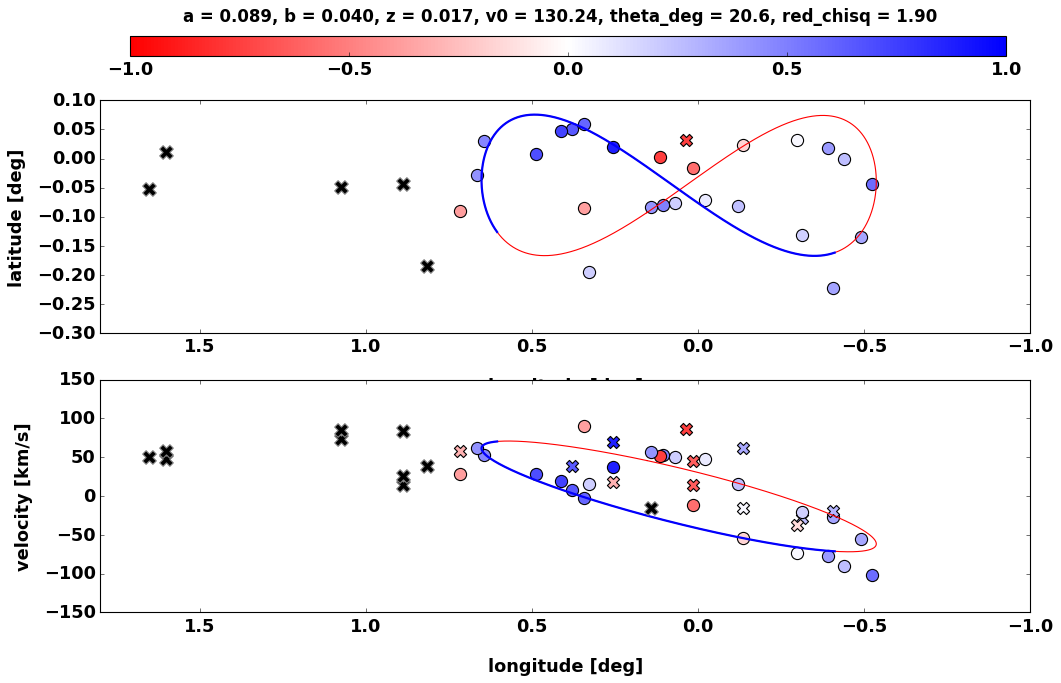

In [63]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings_out = Ring(phi,
                  out.params['a_rings'].value,
                  out.params['b_rings'].value,
                  out.params['z_rings'].value,
                  out.params['v_rings'].value, 
                  np.radians(out.params['theta_rings'].value),
                  xyzsun,vxyzsun)

lb_lv_plots_postcolor(Rings_out)

In [13]:
out = minimize(ring_resid, method='emcee', nan_policy='omit',
               burn=3, steps=10, thin=20,
               params=params, args=(Ndata.l0,Ndata.b0,Ndata.v0),is_weighted=False, progress=True)

emcee: Exception while calling your likelihood function:
  params: [9.00002181e-02 5.49931115e-02 1.24999712e-02 1.30029822e+02
 2.49984830e+01 9.99942535e-03]
  args: (<function ring_resid at 0x7f8e436a2820>, Parameters([('a_rings', <Parameter 'a_rings', value=0.09000021809733452, bounds=[0.01:0.3]>), ('b_rings', <Parameter 'b_rings', value=0.054993111484857214, bounds=[0.01:0.2]>), ('z_rings', <Parameter 'z_rings', value=0.012499971182536753, bounds=[0.0:0.05]>), ('v_rings', <Parameter 'v_rings', value=130.0298215640599, bounds=[100.0:150.0]>), ('theta_rings', <Parameter 'theta_rings', value=24.998482993636156, bounds=[0:180]>), ('ddphi', <Parameter 'ddphi', value=0.001 (fixed), bounds=[5e-05:0.01]>), ('__lnsigma', <Parameter '__lnsigma', value=0.009999425352340571, bounds=[-inf:inf]>)]), ['a_rings', 'b_rings', 'z_rings', 'v_rings', 'theta_rings', '__lnsigma'], array([[1.0e-02, 3.0e-01],
       [1.0e-02, 2.0e-01],
       [0.0e+00, 5.0e-02],
       [1.0e+02, 1.5e+02],
       [0.0e+00,

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/lmfit/minimizer.py", line 1069, in _lnprob
    out = userfcn(params, *userargs, **userkwargs)
  File "/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_79914/2476893591.py", line 23, in ring_resid
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_unsupervised.py", line 166, in fit
    return self._fit(X)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py", line 556, in _fit
    self._tree = KDTree(
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
out

In [13]:
normELL_l, normELL_b, normELL_v = normalizelbv(Rings_out.l,Rings_out.b,Rings_out.vr)
back_ind, fore_ind, y_NF = ring_NF_dist(Rings_out) #finds the N/F on the ellipse
Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

# Try fitting different initial CMZ sizes (change by 100 pc each time?)

In [30]:
agrid = np.arange(0.05, 0.31, 0.05)
bgrid = np.arange(0.05, 0.31, 0.05)

In [31]:
agrid

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

KeyError: 'ddphi'

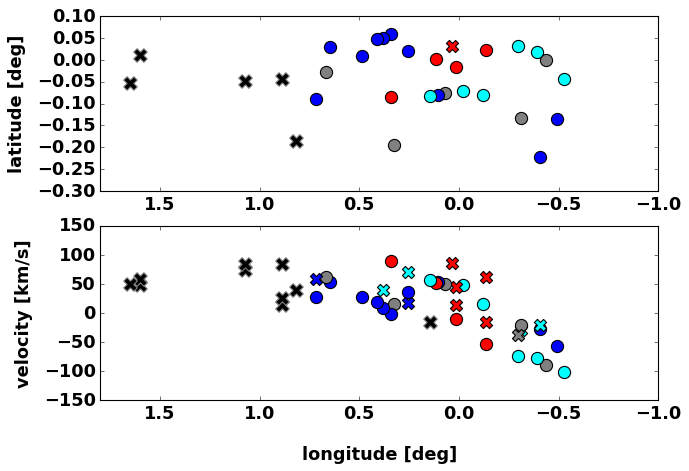

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
fig.set_facecolor('white')
ax[0].set_facecolor('white')

### Scatter cloud points in lbv ###
color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
cmap = (mpl.colors.ListedColormap(color_list))
lines = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5))]
line_col = ['red','orange','goldenrod','green','cyan','black','indigo']

for i in range(0,len(plot_cat_agg)):

    if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
        marker = 'X'
    else:
        marker = 'o'

    if plot_cat_agg['NF_decision'][i] == 'N':
        ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[0], s=120 )
    if plot_cat_agg['NF_decision'][i] == 'LN':
        ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[1], s=120)
    if plot_cat_agg['NF_decision'][i] == 'U':
        ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[2], s=120)
    if plot_cat_agg['NF_decision'][i] == 'LF':
        ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[3], s=120)
    if plot_cat_agg['NF_decision'][i] == 'F':
        ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[4], s=120)
    if plot_cat_agg['NF_decision'][i] == 'nan':
        ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k')


ax[0].set_xlabel('longitude [deg]', labelpad=20)
ax[0].set_ylabel('latitude [deg]', labelpad=10)
ax[0].set_xlim(1.8,-1.)
ax[0].set_ylim(-0.3,0.1)




for i in range(0,len(plot_tab)):

    if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
        marker = 'X'
    else:
        marker = 'o'

    if plot_tab['NF_decision'][i] == 'N':
        ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[0], s=120 )
    if plot_tab['NF_decision'][i] == 'LN':
        ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[1], s=120)
    if plot_tab['NF_decision'][i] == 'U':
        ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[2], s=120)
    if plot_tab['NF_decision'][i] == 'LF':
        ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[3], s=120)
    if plot_tab['NF_decision'][i] == 'F':
        ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[4], s=120)
    if plot_tab['NF_decision'][i] == 'nan':
        ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k')






ax[1].set_xlabel('longitude [deg]', labelpad=20)
ax[1].set_ylabel('velocity [km/s]', labelpad=10)
ax[1].set_xlim(1.8,-1.)
ax[1].set_ylim(-150,150)
    

for i in range(len(agrid)):

    params_GRID = create_params(a_rings={'value': agrid[i]   , 'min': 0.01, 'max': 0.3, 'vary': True},
                               b_rings={'value': bgrid[i]  , 'min': 0.01, 'max': 0.2, 'vary': True},
                               z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                               v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                               theta_rings={'value': 25  , 'min': 15, 'max': 360, 'vary': True}
                                  )
    
    out = minimize(ring_resid, params_GRID, args=(Ndata.l0,Ndata.b0,Ndata.v0))

    
    dphi = np.radians(0.001)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

    Rings_out = Ring(phi,
                      out.params['a_rings'].value,
                      out.params['b_rings'].value,
                      out.params['z_rings'].value,
                      out.params['v_rings'].value, 
                      np.radians(out.params['theta_rings'].value),
                      xyzsun,vxyzsun)
    
    back_ind = np.where(Rings_out.y>y_offset)
    fore_ind = np.where(Rings_out.y<=y_offset)
    
    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings_out.l[back_ind[0:-1]]),np.degrees(Rings_out.b[back_ind[0:-1]]),c=line_col[i], linestyle=lines[i], label='a={:.2f}'.format(agrid[i]))
    ax[0].plot(np.degrees(Rings_out.l[fore_ind[0:]]),np.degrees(Rings_out.b[fore_ind[0:]]),c=line_col[i], linestyle=lines[i], linewidth=2, zorder=2)
    
    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings_out.l[back_ind[0:-1]]),Rings_out.vr[back_ind[0:-1]],c=line_col[i],linestyle=lines[i])
    ax[1].plot(np.degrees(Rings_out.l[fore_ind[0:]]),Rings_out.vr[fore_ind[0:]],c=line_col[i], linestyle=lines[i],linewidth=2, zorder=2)   
    
    ax[0].legend(loc='best', bbox_to_anchor=(1.1, 0.9))
    
plt.show()


In [ ]:
back_ind

In [ ]:
fore_ind

In [ ]:
np.where(back_ind[0]==fore_ind[0][-1])